In [1]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [4]:
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 4})

In [5]:
query = """


	SELECT
		CASE
			WHEN DATE(transaction_date) BETWEEN '2013-07-01' AND '2014-07-01' THEN '2014'
			WHEN DATE(transaction_date) BETWEEN '2014-07-01' AND '2015-07-01' THEN '2015' 
			WHEN DATE(transaction_date) BETWEEN '2015-07-01' AND '2016-07-01' THEN '2016' 
			WHEN DATE(transaction_date) BETWEEN '2016-07-01' AND '2017-07-01' THEN '2017' 
		END AS fiscal_year_transaction,
		CASE 
			WHEN MONTH(DATE(transaction_date)) BETWEEN 7 AND 9 THEN 'Q1'
			WHEN MONTH(DATE(transaction_date)) BETWEEN 10 AND 12 THEN 'Q2'
			WHEN MONTH(DATE(transaction_date)) BETWEEN 1 AND 3 THEN 'Q3'
			WHEN MONTH(DATE(transaction_date)) BETWEEN 4 AND 6 THEN 'Q4'
		END AS fiscal_year_quarter,

		COUNT(b.order_course_id) AS cnt_verifications,
		COUNT(DISTINCT b.order_username) AS cnt_verified_users,
		CAST(SUM(COALESCE(transaction_amount, 0)) AS INT) AS total_bookings
	FROM
		production.d_user a
	JOIN
		production.d_country c
	ON
		a.user_last_location_country_code = c.user_last_location_country_code
	AND
		c.country_name IN
		(
		'Argentina',
		'Bolivia',
		'Chile',
		'Colombia',
		'Costa Rica',
		'Cuba',
		'Dominican Republic',
		'Ecuador',
		'El Salvador',
		'Guatemala',
		'Honduras',
		'Mexico',
		'Nicaragua',
		'Panama',
		'Paraguay',
		'Peru',
		'Puerto Rico',
		'Spain',
		'Uruguay',
		'Venezuela'
		)
	LEFT JOIN
		finance.f_orderitem_transactions b
	ON
		a.user_username = b.order_username
	JOIN
    	business_intelligence.course_master e
	ON
	    b.order_course_id = e.course_id
	AND
	    e.is_wl = 0
	GROUP BY
		1,2



"""

In [6]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(query)
extract = cur.fetchall()
df = pd.DataFrame(extract)

connection.close()

In [7]:
df.head()

,fiscal_year_transaction,fiscal_year_quarter,cnt_verifications,cnt_verified_users,total_bookings
0,2015,Q3,3079,2667,124198
1,2017,Q1,7824,6624,375739
2,2014,Q1,32,30,1615
3,2017,Q2,7793,6512,418490
4,2015,Q4,3914,3478,162565


In [11]:
df_agg = df.groupby('fiscal_year_transaction').sum()

In [17]:
df_agg

,cnt_verifications,cnt_verified_users,total_bookings
fiscal_year_transaction,,,
2014,1500,1312,74172
2015,9136,8054,403701
2016,24648,21792,1078361
2017,36183,30830,1954374


In [18]:
df_agg.reset_index()

,fiscal_year_transaction,cnt_verifications,cnt_verified_users,total_bookings
0,2014,1500,1312,74172
1,2015,9136,8054,403701
2,2016,24648,21792,1078361
3,2017,36183,30830,1954374


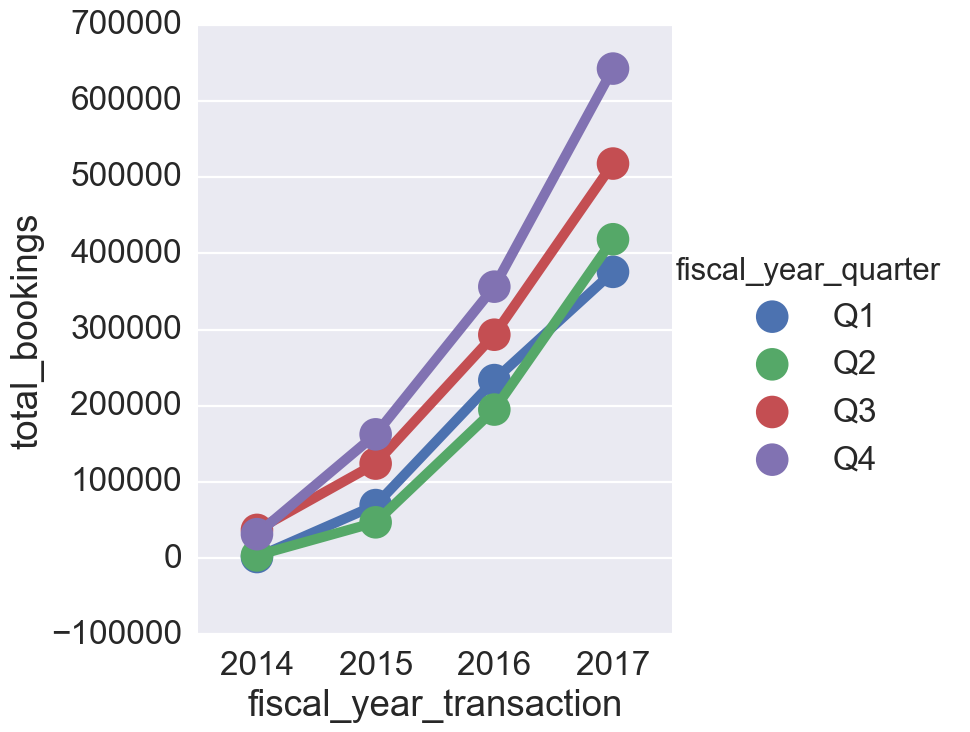

In [25]:
sns.factorplot(
    data = df,
    x = 'fiscal_year_transaction',
    y = 'total_bookings',
    hue = 'fiscal_year_quarter',
    kind = 'point',
    hue_order = ['Q1', 'Q2', 'Q3', 'Q4'],
    order = ['2014', '2015', '2016', '2017'],
    size = 8
    
sns.lmplot(x="sepal_length", y="sepal_width", hue="species",
               truncate=True, size=5, data=iris)

)

In [31]:
df[df['fiscal_year_transaction']>'2014']

,fiscal_year_transaction,fiscal_year_quarter,cnt_verifications,cnt_verified_users,total_bookings
0,2015,Q3,3079,2667,124198
1,2017,Q1,7824,6624,375739
3,2017,Q2,7793,6512,418490
4,2015,Q4,3914,3478,162565
5,2017,Q3,8856,7542,517780
7,2016,Q1,6292,5607,233727
9,2017,Q4,11710,10152,642365
12,2016,Q2,4216,3675,195070
13,2016,Q3,5669,5035,293268
14,2016,Q4,8471,7475,356296


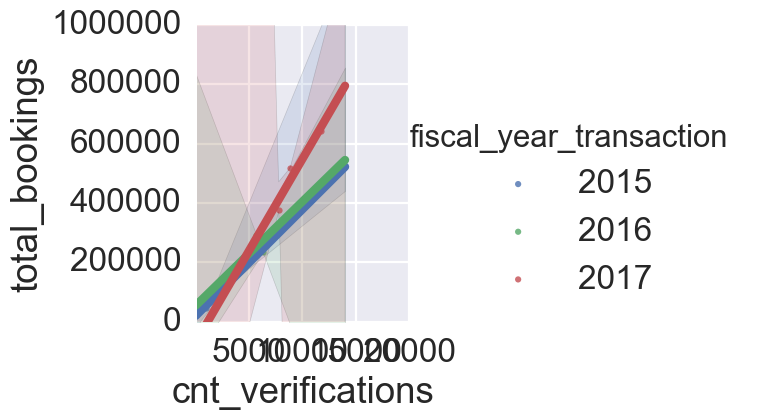

In [35]:
ax = sns.lmplot(x="cnt_verifications", y="total_bookings", hue="fiscal_year_transaction",size=5, 
           data=df[df['fiscal_year_transaction']>'2014'])
ax.set(ylim=(0,1000000),
      xlim=(100,20000))

In [20]:
df.dtypes

fiscal_year_transaction    object
fiscal_year_quarter        object
cnt_verifications           int64
cnt_verified_users          int64
total_bookings              int64
dtype: object

In [26]:
df = df.sort_values(['fiscal_year_transaction', 'fiscal_year_quarter'])

In [27]:
df

,fiscal_year_transaction,fiscal_year_quarter,cnt_verifications,cnt_verified_users,total_bookings
2,2014,Q1,31,29,1565
6,2014,Q2,83,76,3900
8,2014,Q3,748,659,37515
11,2014,Q4,650,559,31892
14,2015,Q1,1197,1084,69701
16,2015,Q2,943,823,47366
0,2015,Q3,3087,2669,124286
4,2015,Q4,3940,3494,164165
7,2016,Q1,6324,5636,235842
12,2016,Q2,4238,3687,196072


In [40]:
df.groupby(['fiscal_year_transaction']).cumsum()

,cnt_verifications,cnt_verified_users,total_bookings,cumulative_bookings
2,31,29,1565,1565
6,114,105,5465,5465
8,862,764,42980,42980
11,1512,1323,74872,74872
14,1197,1084,69701,69701
16,2140,1907,117067,117067
0,5227,4576,241353,241353
4,9167,8070,405518,405518
7,6324,5636,235842,235842
12,10562,9323,431914,431914


In [44]:
df['cumulative_bookings'] = df.groupby(['fiscal_year_transaction']).cumsum()['total_bookings']/1E6

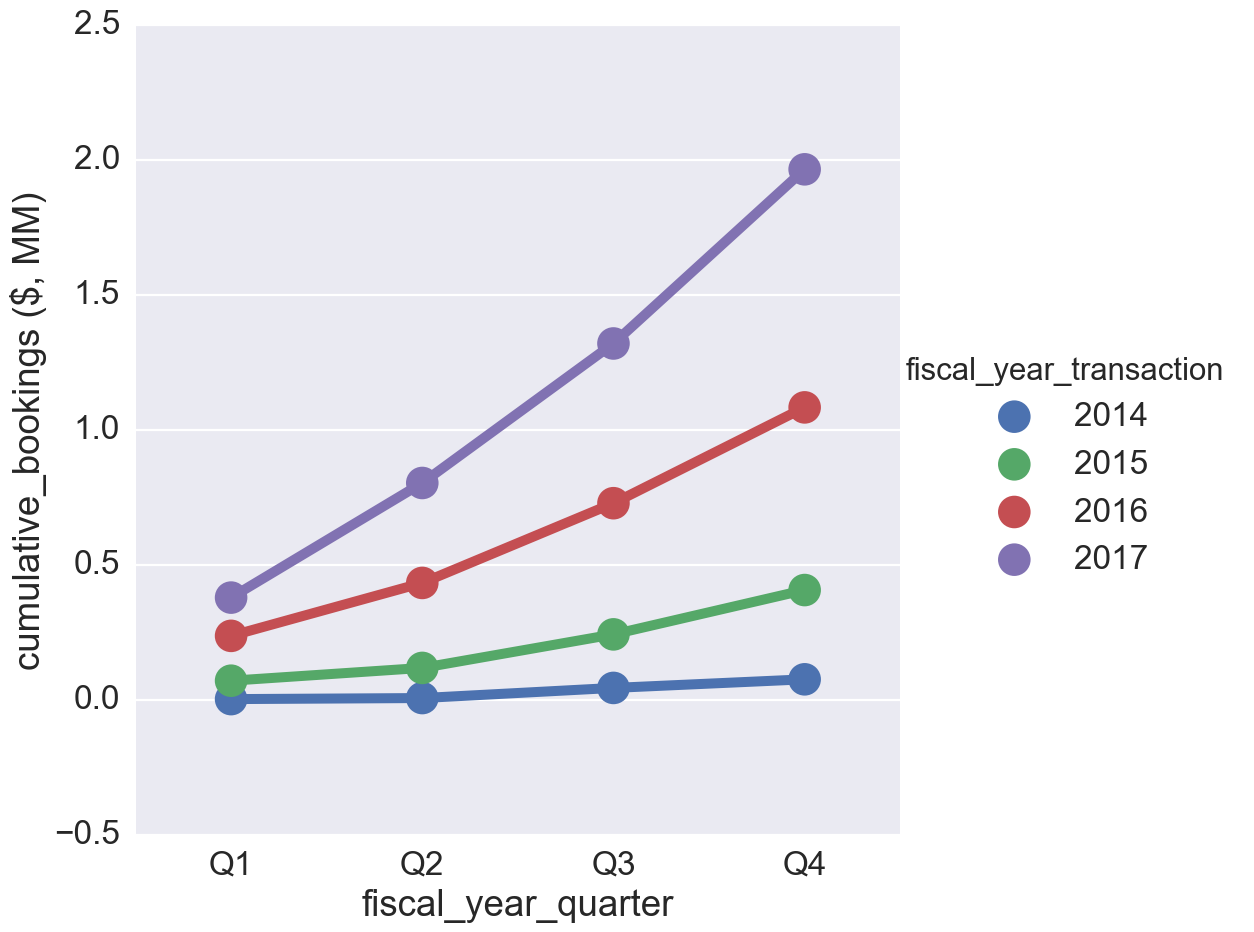

In [52]:
ax = sns.factorplot(data = df, x = 'fiscal_year_quarter', 
               y = 'cumulative_bookings', 
               hue = 'fiscal_year_transaction',
               kind = 'point',
              size = 10,
             )
ax.set(ylabel = 'cumulative_bookings ($, MM)')

In [54]:
df.to_csv('./spanish_learners_transaction_per_fy.csv')